# 单位圆内均匀分布的散点与K-Means聚类中心
假设有一群点均匀地分布在单位圆中，我们要使用Kmeans算法强行将他们聚成两个类。
问题：
1. 最终两个类会聚集成什么样？
2. 两个类的中心坐标是多少？

针对第一个问题，首先我们需要回忆一下Kmeans算法的工作原理：  
1. 随机选取k个簇的中心点：$\varsigma_1, \varsigma_2, ..., \varsigma_k$  
2. 计算每个样本点$x^(i)$对应的类$c^{(i)}$   
    $\  c^{i} \ := arg \ \min_j \  ||x^{(i)}-\varsigma_j||$  
3. 重新计算每个中心的坐标:   
    $\  \varsigma_j \  := \frac{\sum_{i=1}^{m}1\lbrace{c^{(i)}=j}\rbrace x^{(i)}}{\sum_{i=1}^{m}1\lbrace {c^{(i)}=j}\rbrace } $  
    
重复步骤1~3，直到收敛或者达到迭代次数。


那么，问题1的答案：
我们可以猜测：两个类会聚集成两个半圆（被一条直径分割）。两个半圆为具体位置和圆心的初始位置有关。
以下进行实验论证：二分类会行程两个半圆。

首先，我们需要生成一群点，均匀地分布在单位圆中。参考链接：
https://blog.csdn.net/u011396359/article/details/53193615

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def generate_data_in_unit_circle(samples_num=10000):
    X = np.zeros((samples_num, 2))
    radians = np.random.random(size=samples_num) * 2 * np.pi - np.pi
    i_set = np.arange(0,samples_num,1)
    for i in i_set:
        radius = np.sqrt(np.random.random())
        X[i, 0] = np.cos(radians[i]) * radius
        X[i, 1] = np.sin(radians[i]) * radius
    return X

在比较每一个点与每个中心的欧几里得距离时，此处直接比较距离的平方。因为，开方操作增加了计算量，但开方的结果又不用于其他计算。

In [3]:
def square_distance(point_1, point_2):
    return np.sum(np.power(point_1 - point_2, 2))

下面是K-Means聚类算法的实现，此处，我对算法进行了重构。将迭代部分封装成单独函数，便于后面看到每次迭代过程的结果。

In [4]:
# data: x, y of points :numpy.ndarray
# cluster_centroids: the center coordinates of clusters :numpy.ndarray
# n_clusters: the number of final clusters 
def kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters=2):
    row_num, col_num = data.shape
    best_matches = np.zeros((row_num,))
    # Find which centroid is the closest for each point
    for j in range(row_num):
        row = data[j, :]
        best_match = 0
        best_distance = square_distance(cluster_centroids[0, :], row)
        for next_cluster in range(1, n_clusters):
            next_distance = square_distance(cluster_centroids[next_cluster, :], row)
            if next_distance < best_distance:
                best_match = next_cluster
                best_distance = next_distance
        best_matches[j] = best_match
    # Move the centroids to the average of their members
    for i in range(n_clusters):
        pos_flag = (best_matches == i)
        if pos_flag.any():
            cluster_centroids[i] = np.average(data[pos_flag, :])
    return (cluster_centroids, best_matches)

多次调用kmeans_k_cluster_one_iteration，完成整个K-Means算法的迭代过程。
其中，针对讨论的问题，将初始聚类中心初始化在圆的最右边（极端情况），坐标范围在 1.0 < x < 1.1,  -0.1 < y < 0.0。

In [25]:
def kmeans_k_cluster(data, max_iter=100, n_clusters=2):
    # Create n_clusters close centroids
    cluster_centroids = np.array([[1.0 + np.random.random()/10, 0.0 - np.random.random()/10]
                                  for i in range(n_clusters)])
    last_matches = None
    best_matches = None
    for t in range(max_iter):
        print('Iteration %d' % t)
        cluster_centroids, best_matches = kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters)
        # If the results are the same as last time, this is complete
        bool_flag = (best_matches == last_matches)
        if bool_flag.all():
            return (cluster_centroids, best_matches)
        last_matches = best_matches

    return (cluster_centroids, best_matches)

为了查看初始化的聚类中心位置，我们在调用kmeans_k_cluster函数时，设置max_iter=0,那么函数不调用kmeans的迭代过程，直接返回初始聚类中心坐标。
此处生成一张聚类前的散点图：

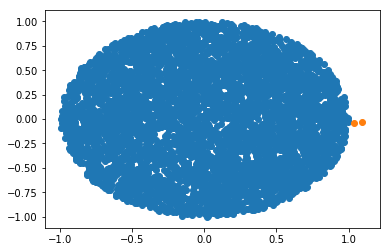

In [26]:
data = generate_data_in_unit_circle(5000)
cluster_centroids, best_matches = kmeans_k_cluster(data, max_iter=0, n_clusters=2)
plt.figure(1)
plt.scatter(data[:, 0], data[:, 1], marker='o')
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])
plt.show()

上图可以看到，我们初始化了一对距离非常近的簇中心。
下面我们连续展示几张，分别迭代了1, 2, 3, 5次的结果。

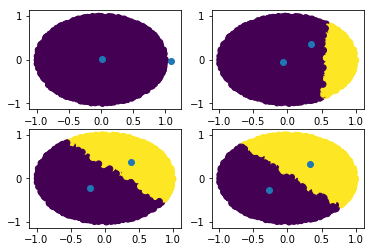

In [27]:
plt.figure(2)
# 1 iter
plt.subplot(221)
cluster_centroids, best_matches = kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters=2)
plt.scatter(data[:, 0], data[:, 1], c=best_matches)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])

# 2 iter
plt.subplot(222)
cluster_centroids, best_matches = kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters=2)
plt.scatter(data[:, 0], data[:, 1], c=best_matches)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])

# 3 iter
plt.subplot(223)
cluster_centroids, best_matches = kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters=2)
plt.scatter(data[:, 0], data[:, 1], c=best_matches)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])

# 5 iter
plt.subplot(224)
for i in range(2):
    cluster_centroids, best_matches = kmeans_k_cluster_one_iteration(data, cluster_centroids, n_clusters=2)
plt.scatter(data[:, 0], data[:, 1], c=best_matches)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])
plt.show()

有了对第一个问题的理解，对于第2题，就简单了。
由于K-Means算法会把散点聚类成两个半圆，那么，半圆怎么切，肯定就和初始聚类中心的位置有关了。
但是既然会聚类成两个半圆，那么每个半圆的中心距离圆心的距离就固定了。
因此，我们开始求距离圆心的距离。
下面使用scikit-learn内置的K-Means算法来计算。

In [30]:
data = generate_data_in_unit_circle(1000000)
kmeans = KMeans(n_clusters=2, random_state=0,algorithm="full").fit(data)
predit_labels = kmeans.labels_
cluster_centroids = kmeans.cluster_centers_
print("centers: \n", cluster_centroids)
distance = np.power(cluster_centroids, 2)
print("The distance between the center of cirle and cluster centroids: ", np.sqrt(center_x_y_square[:, 0] + center_x_y_square[:, 1]))

centers: 
 [[-0.15761792 -0.39028234]
 [ 0.15912398  0.39761419]]
The distance between the center of cirle and cluster centroids:  [ 0.42691097  0.42205467]


聚类中心到圆心的距离为0.42左右。此处由于电脑配置原因，只随机生成了1,000,000个点。计算结果并不精确。
下面同样将图绘制出来。

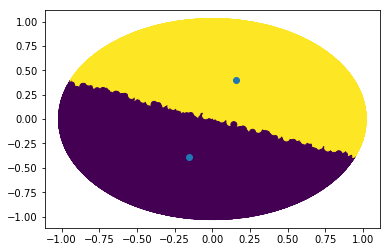

In [33]:
plt.scatter(data[:, 0], data[:, 1], c=predit_labels)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1])
plt.show()

到此位置，通过编程计算结束。下面继续通过理论计算,进行相互印证。计算散点是均匀分布在单位圆上，每个簇形成一个半圆。
那么，站在物理的角度，每个簇的中心应该也是它的质心。
因此，质心在一条半径上，同时，垂直于半径经过中心的线也将单元均分为两个面积相等的部分。示例图:
<img src='./2_clusters.png' />

设 $\angle BOC = \theta$  
$S_{circle} = \pi \times r^2 $  
$S_{\Delta BOC}=\sin {\frac{\theta}{2}} \cos {\frac{\theta}{2}}$   
$S_{Sector BOC}= \frac{1}{2} \theta \times r^2$   
$ r = 1$   
$ \pi \times r^2 \times \frac{1}{4} = S_{Sector BOC} - S_{\Delta BOC}$

最终化简后，$\theta - \sin (\theta) = \frac{\pi}{2}$  
$\theta = 1.75$弧度左右  
簇中心到圆心的距离：0.41左右